**Название проекта: Выбор локации для скважины**

## Введение

**Описание проекта**

Нефтедобывающая компания «ГлавРосГосНефть» принимает решение, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, характеристики (качество нефти и объём её запасов) для каждой скважины в регионе уже известны. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски техникой *Bootstrap.*

*Шаги для выбора локации:*

* В избранном регионе ищут месторождения, для каждого определяют значения признаков (качество нефти и объём её запасов);
* Строят модель для предсказания объёма запасов в новых скважинах, оценивают объём запасов;
* Выбирают месторождения с самым высокими оценками значений;  
Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
* Определяют регион с максимальной суммарной прибылью отобранных месторождений.

---
**Задачи исследования**

* провести предобработку и анализ данных
* подготовить данные
* обучить и проверить модель для каждого региона
* провести подготовку к расчёту прибыли:

рассчитать достаточный объём сырья для безубыточной разработки новой скважины  
cравнить полученный объём сырья со средним запасом в каждом регионе

* рассчитать риски и прибыль для каждого региона
* сформулировать выводы, дать рекомендации

---
**Цель исследования** - построить модель для определения региона, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски с применением техники Bootstrap

---
**Данные для анализа**

*datasets/geo_data_0.csv* - данные геологоразведки по первому региону

*datasets/geo_data_1.csv* - данные геологоразведки по второму региону

*datasets/geo_data_2.csv* - данные геологоразведки по третьему региону

---
**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
* Бюджет на разработку скважин в регионе — 10 млрд рублей;
* Доход с 1 барреля сырья = 450 руб.  Доход с каждой единицы продукта = 450 тыс. рублей (объём указан в тыс. баррелей);
* После оценки рисков оставить регионы, в которых вероятность убытков < 2.5% / cреди них выбирают регион с наибольшей средней прибылью;
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

---
**Описание данных**

* *id* — уникальный идентификатор скважины
* *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы)
* *product* — объём запасов в скважине (тыс. баррелей)

---
**Этапы работы над проектом**

*Шаг 1.* Загрузка и подготовка данных

* загрузка данных
* изучение общей информации
* исследовательский анализ
* подготовка данных
* корреляционный анализ

*Шаг 2.* Обучение и проверка модели

*Шаг 3.* Подготовка к расчету прибыли

* сохранение переменных с ключевыми значениями для расчётов
* расчет "точки безубыточности" (достаточного объёма сырья для безубыточной разработки новой скважины)

*Шаг 4.* Расчет прибыли и рисков

*Шаг 5.* Общий вывод 

In [361]:
!pip uninstall -y scikit-learn -q
!pip install scikit-learn==1.2.0 -q
!pip install --upgrade numba -q
!pip install --upgrade scipy -q
!pip install seaborn --upgrade -q
!pip install numpy==1.23 -q
!pip install phik -q

In [364]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from phik.report import plot_correlation_matrix
from phik import report

In [365]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

### Загрузка данных

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы:

*geo_data_0* - данные файла geo_data_0.csv (данные геологоразведки по первому региону)  
*geo_data_1* - данные файла geo_data_1.csv (данные геологоразведки по второму региону)  
*geo_data_2* - данные файла geo_data_2.csv (данные геологоразведки по третьему региону)

***Для удобства в дальнейшем будем обозначать:  
данные по нулевому, первому и второму региону - geo_data_0, geo_data_1 и geo_data_2 соответственно.***

In [366]:
pth01 = '/datasets/geo_data_0.csv'
pth02 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'

if os.path.exists(pth01):
    geo_data_0 = pd.read_csv(pth01)
elif os.path.exists(pth02):
    geo_data_0 = pd.read_csv(pth02)
else:
    print('Файл не найден')

In [367]:
pth11 = '/datasets/geo_data_1.csv'
pth12 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'

if os.path.exists(pth11):
    geo_data_1 = pd.read_csv(pth11)
elif os.path.exists(pth12):
    geo_data_1 = pd.read_csv(pth12)
else:
    print('Файл не найден')

In [368]:
pth21 = '/datasets/geo_data_2.csv'
pth22 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

if os.path.exists(pth21):
    geo_data_2 = pd.read_csv(pth21)
elif os.path.exists(pth22):
    geo_data_2 = pd.read_csv(pth22)
else:
    print('Файл не найден')

### Изучение общей информации

На этом этапе изучим общую информацию о каждом датафрейме. Проверим, что данные в таблицах соответствуют описанию.

---
>В целях оптимизации кода для получения информации о каждом датафрейме создадим функцию **check_df**

In [369]:
def check_df(df):
    display(df.head())
    print('------------------------------------------------------------')
    display(df.info())
    print('------------------------------------------------------------')
    print('Наименования столбцов:', df.columns)
    print('------------------------------------------------------------')
    display('Количество пропусков:', (df.isna().sum()))
    print('------------------------------------------------------------')
    display(f'Количество дубликатов: {df.duplicated().sum()}') 
    print('------------------------------------------------------------')
 
    # проверка значений в столбце id на уникальность
    total = len(df['id'])
    unique = len(df['id'].unique())
    if total - unique == 0:
        print('Значения в столбце id уникальны')
    else:
        print(f'Значения в столбце id не уникальны: всего {total} значений, из них {unique} уникальных')

---
* **Датафрейм geo_data_0**

In [370]:
check_df(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------------------------------------------------------
Наименования столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
------------------------------------------------------------


'Количество пропусков:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------------------------------------------------------


'Количество дубликатов: 0'

------------------------------------------------------------
Значения в столбце id не уникальны: всего 100000 значений, из них 99990 уникальных


* **Датафрейм geo_data_1**

In [371]:
check_df(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------------------------------------------------------
Наименования столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
------------------------------------------------------------


'Количество пропусков:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------------------------------------------------------


'Количество дубликатов: 0'

------------------------------------------------------------
Значения в столбце id не уникальны: всего 100000 значений, из них 99996 уникальных


* **Датафрейм geo_data_2**

In [372]:
check_df(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

------------------------------------------------------------
Наименования столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
------------------------------------------------------------


'Количество пропусков:'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------------------------------------------------------


'Количество дубликатов: 0'

------------------------------------------------------------
Значения в столбце id не уникальны: всего 100000 значений, из них 99996 уникальных


---
При изучении общей информации было выявлено, что во всех трех рассматриваемых датафреймах значения в столбце 'id' не уникальны, следовательно столбец 'id' не информативен и во всех трех датафреймах его можно удалить:

In [373]:
# удалим столбец 'id' во всех трех датафреймах
geo_data_0.drop('id', axis=1, inplace=True)
geo_data_1.drop('id', axis=1, inplace=True)
geo_data_2.drop('id', axis=1, inplace=True)

In [374]:
# выполним проверку
display(geo_data_0.head(1))
display(geo_data_1.head(1))
display(geo_data_2.head(1))

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


,f0,f1,f2,product
0,-15.001348,-8.276,-0.005876,3.179103


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673


---
После удаления столбца 'id' проведем проверку на наличие дубликатов во всех трех датафреймах :

In [375]:
print(f'Количество дубликатов в датафрейме geo_data_0: {geo_data_0.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме geo_data_0: {geo_data_1.duplicated().sum()}') 
print(f'Количество дубликатов в датафрейме geo_data_0: {geo_data_2.duplicated().sum()}') 

Количество дубликатов в датафрейме geo_data_0: 0
Количество дубликатов в датафрейме geo_data_0: 0
Количество дубликатов в датафрейме geo_data_0: 0


---
**Вывод:**

В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов.
    
Каждый датафрейм = регион, каждая строка = месторождение, каждый столбец = параметр, который содержит информацию о месторождении.  
Описание каждой скважины включает в себя следующие параметры:
    
* *id* — уникальный идентификатор скважины
* *f0, f1, f2* — три признака точек
* *product* — объём запасов в скважине (тыс. баррелей)

---
* пропущенных значений в данных нет 
* с типами данных все в порядке  
* названия столбцов указаны в корректном формате

При изучении общей информации было выявлено, что во всех трех рассматриваемых датафреймах значения в столбце 'id' не уникальны, т.к. эти данные не информативны, на этом этапе мы удалили столбец 'id' в каждом из датафреймов, после чего провели повторную проверку на наличие дубликатов.

### Иcследовательский анализ данных

На этом этапе для каждого из датафреймов мы рассмотрим основные статистические характеристики признаков, построим графики распределения и диаграммы размаха (все признаки - количественные), определим выбросы.

>Для построения графиков (график распределения + диаграмма размаха) создадим функцию **all_graphs**  

In [376]:
def all_graphs (df, name, number_bins):
    
    cols_list = df.columns.tolist()
    
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'Графики распределения для датафрейма {name}', fontsize = 15, fontweight='bold')

    i=1

    for t in cols_list:
        plt.subplot(1, 4, i)
        plt.hist(df[t], edgecolor='black', bins=number_bins)
        plt.title(f'{t}', fontsize=15)
        plt.ylabel(f'{t}', fontsize=14)
        i = i+1
    
    plt.tight_layout()
    plt.show() 
        
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'Диаграммы размаха для датафрейма {name}', fontsize = 15, fontweight='bold')

    i=1

    for t in cols_list:
        plt.subplot(1, 4, i)
        df.boxplot(column=t, fontsize=14, vert=False)
        plt.title(f'{t}', fontsize=15)
        plt.ylabel(f'{t}', fontsize=14)
        i = i+1
        
    plt.tight_layout()
    plt.show()

>Для удобства работы с выбросами создадим функцию **outliers_index**  
(функция вычисляет индексы строк с выбросами с использованием метода межквартильного размаха)

* на входе функция принимает название датасета (df), название столбца (column)
* результат работы функции - список с индексами строк, которые содержат выбросы

In [377]:
def outliers_index(df, column):
    
    q25 = np.array(df[column].quantile(0.25))
    q75 = np.array(df[column].quantile(0.75))

    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    
    delete_index = []
    for index_value, value in zip(df[column].index, df[column]):
        if value < lower_bound or value > upper_bound:
            delete_index.append(index_value)
    
    return delete_index

---
* **Датафрейм geo_data_0**

In [378]:
geo_data_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


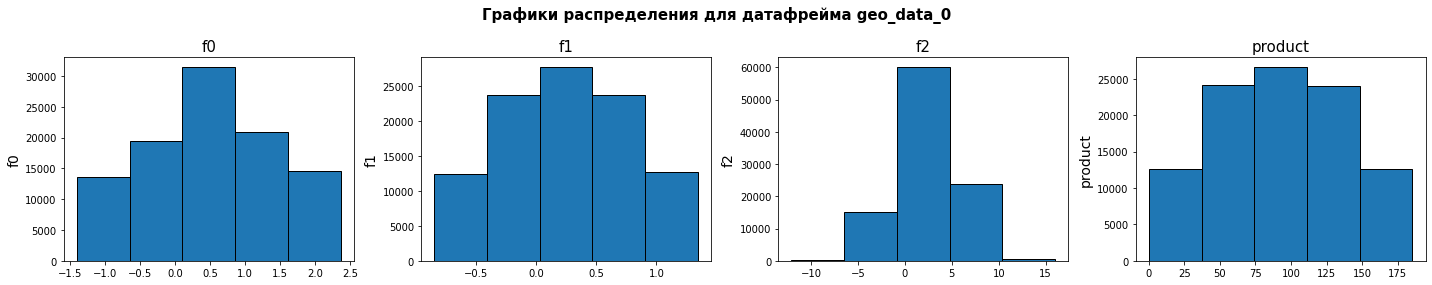

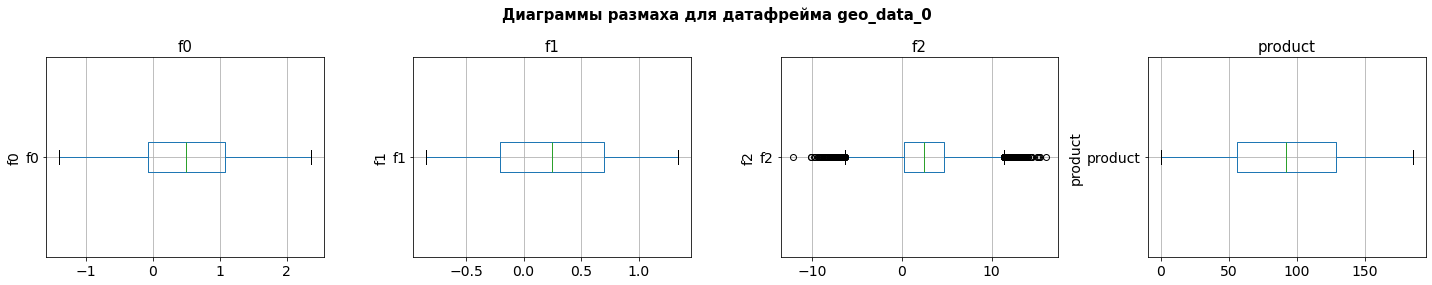

In [379]:
all_graphs (geo_data_0, 'geo_data_0', 5)

Распределение всех показателей - близкое к нормальному.

Выбросы присутствуют только в столбце 'f2'.

При помощи функции outliers_index определим количество строк с выбросами, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_0.

In [380]:
print('Определение выбросов с помощью метода межквартильного размаха')
print('--------------------------------------------------------------')
print('Всего cтрок с выбросами:', len(outliers_index(geo_data_0, 'f2')))
print('Строки с выбросами составляют от всего датафрейма:', \
      round((len(outliers_index(geo_data_0, 'f2')) / len(geo_data_0))*100,2), '%')

Определение выбросов с помощью метода межквартильного размаха
--------------------------------------------------------------
Всего cтрок с выбросами: 506
Строки с выбросами составляют от всего датафрейма: 0.51 %


---
Определим выбросы в столбце 'f2' с помощью диаграммы размаха, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_0.

(-6.5, 11.5)

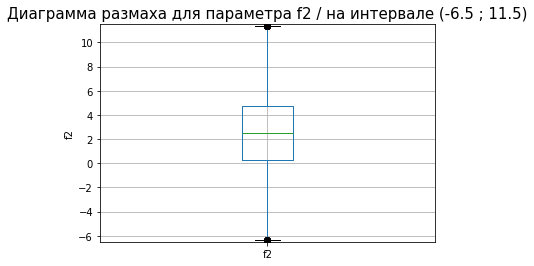

In [381]:
# зададим ограничения, чтобы отсечь все выбросы и определить верхнюю и нижнюю границы отсечения данных
geo_data_0.boxplot(column='f2')
plt.title('Диаграмма размаха для параметра f2 / на интервале (-6.5 ; 11.5)', fontsize=15)
plt.ylabel('f2')
plt.ylim(-6.5, 11.5)

In [382]:
print('Определение выбросов с помощью диаграммы размаха')
print('--------------------------------------------------------------')
print('Всего cтрок с выбросами:', len(geo_data_0.query('f2 > 11.5 or f2 <-6.5')))
print('Строки с выбросами составляют от всего датафрейма:', \
      round((len(geo_data_0.query('f2 > 11.5 or f2 <-6.5')) / len(geo_data_0))*100,2), '%')

Определение выбросов с помощью диаграммы размаха
--------------------------------------------------------------
Всего cтрок с выбросами: 452
Строки с выбросами составляют от всего датафрейма: 0.45 %


---
* **Датафрейм geo_data_1**

In [383]:
geo_data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


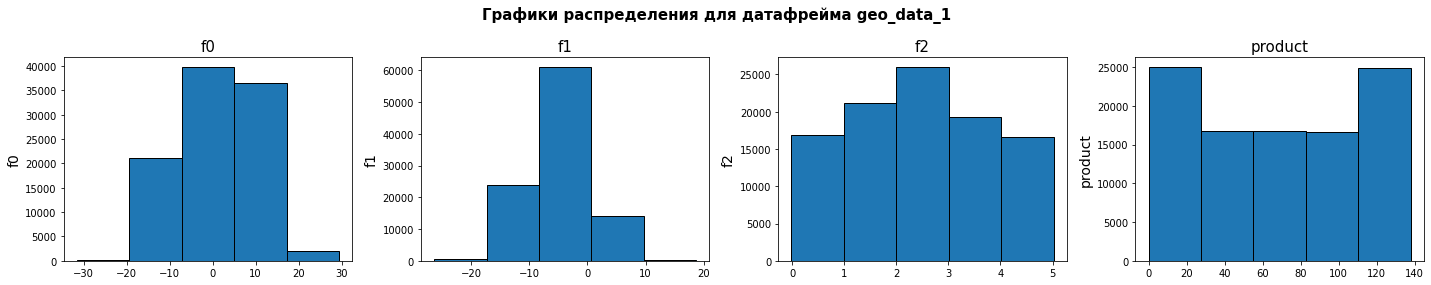

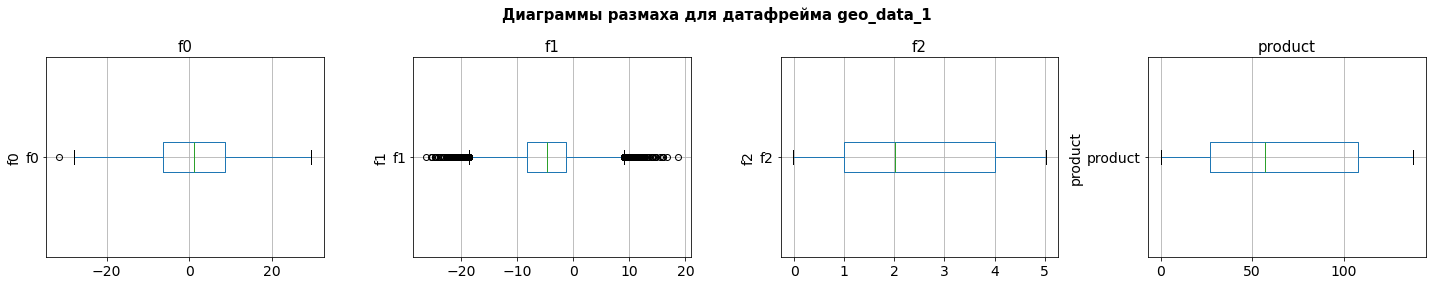

In [384]:
all_graphs (geo_data_1, 'geo_data_1', 5)

Распределение всех показателей, кроме 'product' - близкое к нормальному.

Выбросы присутствуют только в столбце 'f1'.

При помощи функции outliers_index определим количество строк с выбросами, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_1.

In [385]:
print('Определение выбросов с помощью метода межквартильного размаха')
print('--------------------------------------------------------------')
print('Всего cтрок с выбросами:', len(outliers_index(geo_data_1, 'f1')))
print('Строки с выбросами составляют от всего датафрейма:', \
      round((len(outliers_index(geo_data_1, 'f1')) / len(geo_data_1))*100,2), '%')

Определение выбросов с помощью метода межквартильного размаха
--------------------------------------------------------------
Всего cтрок с выбросами: 636
Строки с выбросами составляют от всего датафрейма: 0.64 %


---
Определим выбросы в столбце 'f1' с помощью диаграммы размаха, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_1.

(-19.0, 9.5)

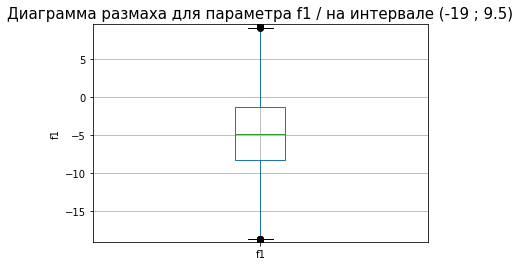

In [386]:
# зададим ограничения, чтобы отсечь все выбросы и определить верхнюю и нижнюю границы отсечения данных
geo_data_1.boxplot(column='f1')
plt.title('Диаграмма размаха для параметра f1 / на интервале (-19 ; 9.5)', fontsize=15)
plt.ylabel('f1')
plt.ylim(-19, 9.5)

In [387]:
print('Определение выбросов с помощью диаграммы размаха')
print('--------------------------------------------------------------')
print('Всего cтрок с выбросами:', len(geo_data_1.query('f1 > 9.5 or f1 < -19')))
print('Строки с выбросами составляют от всего датафрейма:', \
      round((len(geo_data_1.query('f1 > 9.5 or f1 < -19')) / len(geo_data_1))*100,2), '%')

Определение выбросов с помощью диаграммы размаха
--------------------------------------------------------------
Всего cтрок с выбросами: 500
Строки с выбросами составляют от всего датафрейма: 0.5 %


---
* **Датафрейм geo_data_2**

In [388]:
geo_data_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


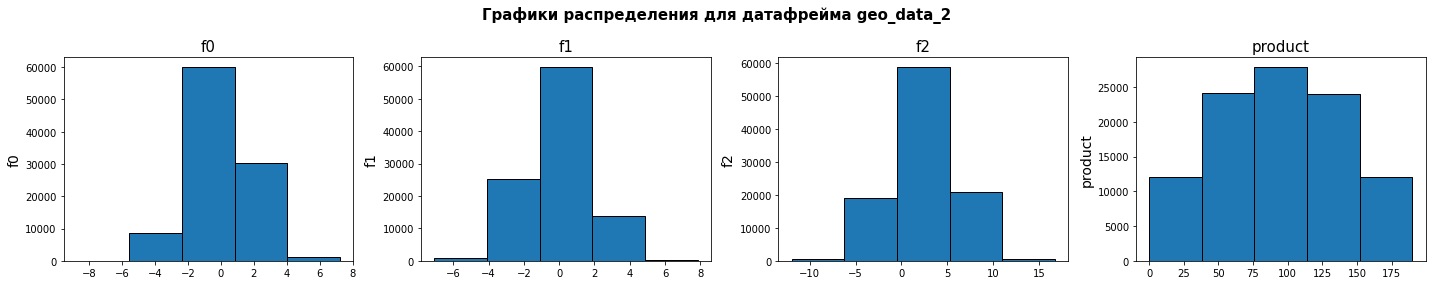

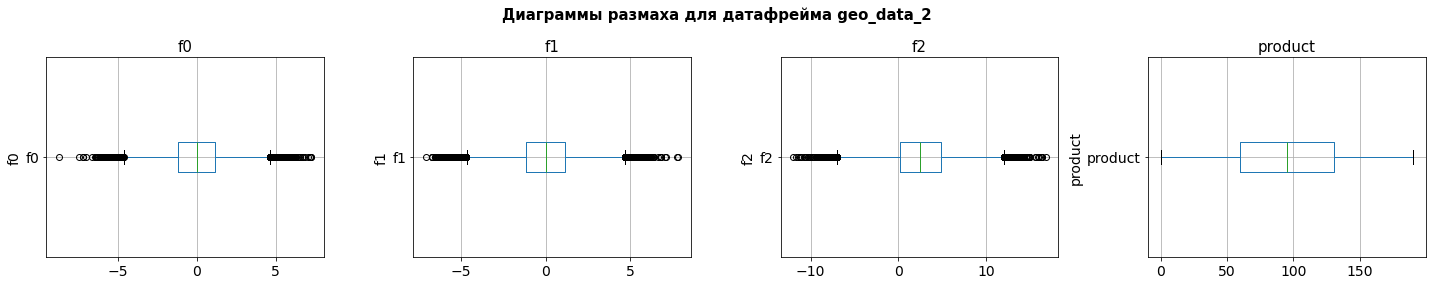

In [389]:
all_graphs (geo_data_2, 'geo_data_2', 5)

Распределение всех показателей - близкое к нормальному.

Выбросы присутствуют в столбцах 'f0', 'f1','f2'.

При помощи функции outliers_index определим количество строк с выбросами, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_2.

In [390]:
len_1 = len(outliers_index(geo_data_2, 'f0'))
len_2 = len(outliers_index(geo_data_2, 'f1'))
len_3 = len(outliers_index(geo_data_2, 'f2'))
len_sum = len_1 + len_2 + len_3

In [391]:
print('Количество выбросов в столбце f0:', len(outliers_index(geo_data_2, 'f0')))
print('Количество выбросов в столбце f1:', len(outliers_index(geo_data_2, 'f1')))
print('Количество выбросов в столбце f2:', len(outliers_index(geo_data_2, 'f2')))
print('------------------------------------------------------------')
print(f'Всего cтрок с выбросами до {len_sum} / некоторые строки с выбросами могут пересекаться')
print('Строки с выбросами составляют от всего датафрейма до', round((len_sum / len(geo_data_2))*100,2), '%')

Количество выбросов в столбце f0: 733
Количество выбросов в столбце f1: 684
Количество выбросов в столбце f2: 584
------------------------------------------------------------
Всего cтрок с выбросами до 2001 / некоторые строки с выбросами могут пересекаться
Строки с выбросами составляют от всего датафрейма до 2.0 %


---
Определим выбросы в столбцах 'f0', 'f1','f2' с помощью диаграммы размаха, а также найдем процент, который строки с выбросами составляют от всего датафрейма geo_data_2.

(-7.0, 12.0)

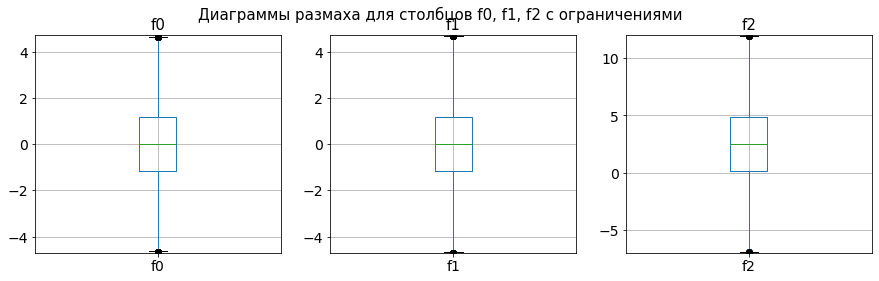

In [392]:
plt.figure(figsize=(15, 4))
plt.suptitle(f'Диаграммы размаха для столбцов f0, f1, f2 c ограничениями', fontsize=15)

plt.subplot(1, 3, 1)
geo_data_2.boxplot(column='f0', fontsize=14)
plt.title('f0', fontsize=15)
plt.ylim(-4.7, 4.7)

plt.subplot(1, 3, 2)
geo_data_2.boxplot(column='f1', fontsize=14)
plt.title('f1', fontsize=15)
plt.ylim(-4.7, 4.7)

plt.subplot(1, 3, 3)
geo_data_2.boxplot(column='f2', fontsize=14)
plt.title('f2', fontsize=15)
plt.ylim(-7, 12)

In [393]:
len_1_ = len(geo_data_2.query('f0 > 4.7 or f0 < -4.7'))
len_2_ = len(geo_data_2.query('f1 > 4.7 or f1 < -4.7'))
len_3_ = len(geo_data_2.query('f2 > 12 or f2 < -7'))
len_sum_ = len_1_ + len_2_ + len_3_

In [394]:
print('Определение выбросов с помощью диаграммы размаха')
print('--------------------------------------------------------------')
print('Количество выбросов в столбце f0:', len_1_)
print('Количество выбросов в столбце f1:', len_2_)
print('Количество выбросов в столбце f2:', len_3_)
print('------------------------------------------------------------')
print(f'Всего cтрок с выбросами до {len_sum_} / некоторые строки с выбросами могут пересекаться')
print('Строки с выбросами составляют от всего датафрейма до', round((len_sum_ / len(geo_data_2))*100,2), '%')

Определение выбросов с помощью диаграммы размаха
--------------------------------------------------------------
Количество выбросов в столбце f0: 667
Количество выбросов в столбце f1: 663
Количество выбросов в столбце f2: 567
------------------------------------------------------------
Всего cтрок с выбросами до 1897 / некоторые строки с выбросами могут пересекаться
Строки с выбросами составляют от всего датафрейма до 1.9 %


---
**Результаты работы с выбросами:**

В данных были выявлены следующие выбросы:
* в датафрейме geo_data_0 - в столбце 'f2'
* в датафрейме geo_data_1 - в столбце 'f1'
* в датафрейме geo_data_2 - в столбцах 'f0', 'f1','f2'

Мы определили выбросы двумя способами: c помощью метода межквартильного размаха и диаграммы размаха, нашли количество строк с выбросами и процент, который строки с выбросами составляют от всего датафрейма.

Результаты определения выбросов с помощью *метода межквартильного размаха*:

* geo_data_0 / 'f2': 506 cтрок с выбросами (0.51 %)
* geo_data_1 / 'f1': 636 cтрок с выбросами (0.64 %)
* geo_data_2 / 'f0', 'f1','f2': соответственно 733, 684, 584 cтрок - общее количество строк с выбросами до 2001 (2 %)

Результаты определения выбросов с помощью *диаграммы размаха*:

* geo_data_0 / 'f2': 452 cтрок с выбросами (0.45 %)
* geo_data_1 / 'f1': 500 cтрок с выбросами (0.5 %)
* geo_data_2 / 'f0', 'f1','f2': соответственно 667, 663, 567 cтрок - общее количество строк с выбросами до 1897 (1.9 %)

Количество строк с выбросами, отпределенное разными способами, отличается несущественно.

---
Метод работы с выбросами уникален для каждого проекта и зависит от конкретной задачи и доступных данных. Отметим, что в данной ситуации для определения выбросов мы будем использовать метод межквартильного размаха.

Согласно условиям задачи, все данные синтетические: детали контрактов и характеристики месторождений не разглашаются, таким образом, мы не можем говорить о реалистичности значений показателей и, соответственно, не можем определить, будут ли являться значения "выбросами" в реальной жизни.

Следовательно, *в условиях засекреченности данных для определения выбросов оптимальным решением будет использовать метод межквартильного размаха*.


---
**Вывод:**
    
Для каждого из датафреймов мы рассмотрели основные статистические характеристики признаков, построили графики распределения и диаграммы размаха (все признаки - количественные), определили выбросы с помощью двух методов: метода межквартильного размаха и диаграммы размаха.

Отметим, что метод межквартильного размаха был выбран, поскольку, согласно условиям задачи, все данные синтетические: детали контрактов и характеристики месторождений не разглашаются, следовательно, мы не можем говорить о реалистичности значений показателей и не можем определить, будут ли являться значения "выбросами" в реальной жизни.

---
Во всех трех рассматриваемых датафреймах в данных есть выбросы.  
Используя метод межквартильного размаха, мы выявили следующее:

* в датафрейме geo_data_0 есть выбросы в столбце 'f2' / количество cтрок с выбросами: 506 (0.51 %)
* в датафрейме geo_data_1 есть выбросы в столбце 'f1' / количество cтрок с выбросами: 636 (0.64 %)
* в датафрейме geo_data_2 есть выбросы в столбцах 'f0', 'f1','f2' / количество cтрок с выбросами: до 2001 (2 %)

---
Таким образом, если мы удалим все строки с выбросами, данные сильно не пострадают.

### Подготовка данных

Перед обучением модели удалим выбросы, поскольку они искажают данные, приводят к неверным результатам о тенденциях и связях, что в конечном итоге может привести к снижению качества модели обучения.

In [395]:
outliers_data = [(geo_data_0,'f2'), (geo_data_1,'f1'), (geo_data_2,'f0'), (geo_data_2,'f1'), (geo_data_2,'f2')]

In [396]:
for df,column in outliers_data:
    indexes = outliers_index(df,column)
    df.drop(indexes, axis = 0, inplace = True)

In [397]:
geo_data_0 = geo_data_0.reset_index(drop = True)
geo_data_1 = geo_data_1.reset_index(drop = True)
geo_data_2 = geo_data_2.reset_index(drop = True)

In [398]:
# проведем проверку / выведем результаты на экран

del_0 = 100000 - len(geo_data_0)
pct_del_0 = round(((100000 - len(geo_data_0)) / len(geo_data_0))*100,2)
del_1 = 100000 - len(geo_data_1)
pct_del_1 = round(((100000 - len(geo_data_1)) / len(geo_data_1))*100,2)
del_2 = 100000 - len(geo_data_2)
pct_del_2 = round(((100000 - len(geo_data_2)) / len(geo_data_2))*100,2)

print(f'В датафрейме geo_data_0 осталось {len(geo_data_0)} строк / удалили {del_0} строк с выбросами ({pct_del_0})%')
print(f'В датафрейме geo_data_1 осталось {len(geo_data_1)} строк / удалили {del_1} строк с выбросами ({pct_del_1})%')
print(f'В датафрейме geo_data_1 осталось {len(geo_data_2)} строк / удалили {del_2} строк с выбросами ({pct_del_2})%')

В датафрейме geo_data_0 осталось 99494 строк / удалили 506 строк с выбросами (0.51)%
В датафрейме geo_data_1 осталось 99364 строк / удалили 636 строк с выбросами (0.64)%
В датафрейме geo_data_1 осталось 98003 строк / удалили 1997 строк с выбросами (2.04)%


---
**Вывод:**
    
На этом этапе мы во всех трех рассматриваемых датафреймах избавились от выбросов (которые были определены с помощью метода межквартильного размаха):

* в датафрейме geo_data_0 осталось 99494 строк / удалили 506 строк с выбросами (0.51)%
* в датафрейме geo_data_1 осталось 99364 строк / удалили 636 строк с выбросами (0.64)%
* в датафрейме geo_data_1 осталось 98003 строк / удалили 1997 строк с выбросами (2.04)%

### Корреляционный анализ

Для того, чтобы выяснить, нет ли утечки целевого признака, а также лучше понять наши данные, проведем корреляционный анализ.  
Так как не все признаки имеют нормальное распределение, будем использовать модуль phik.

* **Датафрейм geo_data_0**

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


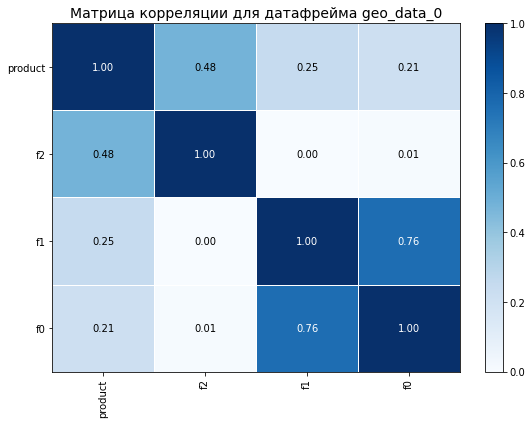

In [399]:
phik_overview_0 = geo_data_0.phik_matrix()

plot_correlation_matrix(
    phik_overview_0.values,
    x_labels=phik_overview_0.columns,
    y_labels=phik_overview_0.index,
    vmin=0, vmax=1, color_map='Blues',
    title='Матрица корреляции для датафрейма geo_data_0',
    figsize=(8, 6)
)
plt.show()

Сильную корреляцию мы видим между признаками: 'f1' / 'f0' = 0.76  
Умеренная корреляция между признаками: 'product' / 'f2' = 0.48

Остальные признаки коррелируют между собой слабо.

* **Датафрейм geo_data_1**

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


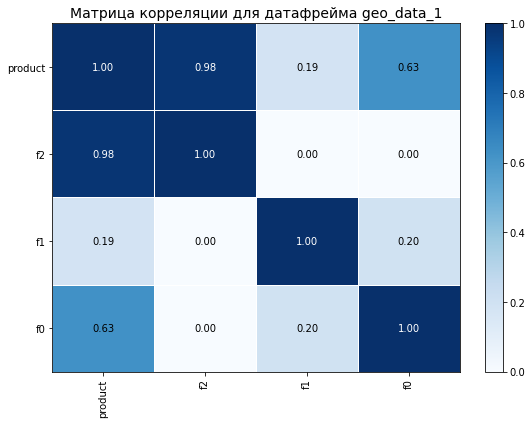

In [400]:
phik_overview_1 = geo_data_1.phik_matrix()

plot_correlation_matrix(
    phik_overview_1.values,
    x_labels=phik_overview_1.columns,
    y_labels=phik_overview_1.index,
    vmin=0, vmax=1, color_map='Blues',
    title='Матрица корреляции для датафрейма geo_data_1',
    figsize=(8, 6)
)
plt.show()

Сильная корреляция между признаками: 'product' / 'f2' = 0.98  
Средняя корреляция между признаками: 'product' / 'f0' = 0.63 
    
Остальные признаки коррелируют между собой слабо.

* **Датафрейм geo_data_2**

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


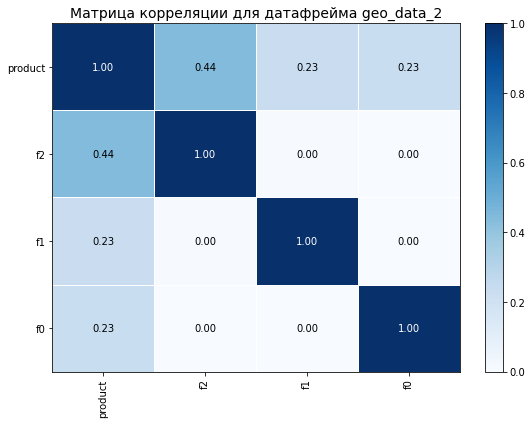

In [401]:
phik_overview_2 = geo_data_2.phik_matrix()

plot_correlation_matrix(
    phik_overview_2.values,
    x_labels=phik_overview_2.columns,
    y_labels=phik_overview_2.index,
    vmin=0, vmax=1, color_map='Blues',
    title='Матрица корреляции для датафрейма geo_data_2',
    figsize=(8, 6)
)
plt.show()

Умеренная корреляция между признаками: 'product' / 'f2' = 0.44  
Остальные признаки коррелируют между собой слабо.

---
Признак 'product' - целевой, удалить признаки, которые коррелируют с целевым мы не можем.  
Сильная корреляция есть между нецелевыми признаками 'f1' / 'f0' (0.76) в датафрейме geo_data_0

На текущий момент оставим датафреймы без изменений. Далее будем отталкиваться от результата, который получим на моделях.

**Вывод**

На данном этапе был проведен корреляционный анализ с использованием модуля phik (т.к. не все признаки имеют нормальное распределение).  
Были пострены матрицы корреляции для всех трех рассматриваемых датафреймов.

* geo_data_0

Сильную корреляцию мы видим между признаками: 'f1' / 'f0' = 0.76  
Умеренная корреляция между признаками: 'product' / 'f2' = 0.48

* geo_data_1

Сильная корреляция между признаками: 'product' / 'f2' = 0.98  
Средняя корреляция между признаками: 'product' / 'f0' = 0.63

* *geo_data_2

Умеренная корреляция между признаками: 'product' / 'f2' = 0.44  

---
Признак 'product' - целевой, удалить признаки, которые коррелируют с целевым мы не можем.  
Отметим, что сильная корреляция есть между нецелевыми признаками 'f1' / 'f0' (0.76) в датафрейме geo_data_0

На текущий момент оставим датафреймы без изменений. Далее будем отталкиваться от результата, который получим на моделях.

---
**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ШАГУ "ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ"**

CSV-файлы с данными мы считали с помощью библиотеки pandas и сохранили в датафреймы *geo_data_0*, *geo_data_1*, *geo_data_2* - данные по нулевому, первому и второму региону соответственно (назвали таким образом для удобства).

---
В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов.
    
Каждый датафрейм = регион, каждая строка = месторождение, каждый столбец = параметр с информацией о месторождении.  
Описание каждой скважины включает в себя следующие параметры:
    
* *id* — уникальный идентификатор скважины
* *f0, f1, f2* — три признака точек
* *product* — объём запасов в скважине (тыс. баррелей)

Во всех трех рассматриваемых датафреймах:

* пропущенных значений в данных нет 
* с типами данных все в порядке  
* названия столбцов указаны в корректном формате

При изучении общей информации было выявлено, что во всех трех рассматриваемых датафреймах значения в столбце 'id' не уникальны, т.к. эти данные не информативны, на этом этапе мы удалили столбец 'id' в каждом из датафреймов, после чего провели повторную проверку на наличие дубликатов.

---
Для каждого из датафреймов мы рассмотрели основные статистические характеристики признаков, построили графики распределения и диаграммы размаха (все признаки - количественные), определили выбросы с помощью двух методов: метода межквартильного размаха и диаграммы размаха.

Отметим, что метод межквартильного размаха был выбран, поскольку, согласно условиям задачи, все данные синтетические: детали контрактов и характеристики месторождений не разглашаются, следовательно, мы не можем говорить о реалистичности значений показателей и не можем определить, будут ли являться значения "выбросами" в реальной жизни.

Во всех трех рассматриваемых датафреймах в данных есть выбросы.  
Используя *метод межквартильного размаха*, мы выявили следующее:

* в датафрейме geo_data_0 есть выбросы в столбце 'f2' / количество cтрок с выбросами: 506 (0.51 %)
* в датафрейме geo_data_1 есть выбросы в столбце 'f1' / количество cтрок с выбросами: 636 (0.64 %)
* в датафрейме geo_data_2 есть выбросы в столбцах 'f0', 'f1','f2' / количество cтрок с выбросами: до 2001 (2 %)

Количество строк с выбросами незначительное, следовательно в результате удаления выбросов данные не пострадают.

---
Перед обучением модели оптимально избавиться от выбросов, поскольку они искажают данные, приводят к неверным результатам о тенденциях и связях, что в конечном итоге может привести к снижению качества модели обучения.

Во всех трех рассматриваемых датафреймах мы *избавились от выбросов* (которые были определены с помощью метода межквартильного размаха).

---
Был проведен *корреляционный анализ с использованием модуля phik* (т.к. не все признаки имеют нормальное распределение).  
Были пострены матрицы корреляции для всех трех рассматриваемых датафреймов.

* geo_data_0

Сильную корреляцию мы видим между признаками: 'f1' / 'f0' = 0.76  
Умеренная корреляция между признаками: 'product' / 'f2' = 0.48

* geo_data_1

Сильная корреляция между признаками: 'product' / 'f2' = 0.98  
Средняя корреляция между признаками: 'product' / 'f0' = 0.63

* *geo_data_2

Умеренная корреляция между признаками: 'product' / 'f2' = 0.44  

Признак 'product' - целевой, удалить признаки, которые коррелируют с целевым мы не можем.  
Отметим, что сильная корреляция есть между нецелевыми признаками 'f1' / 'f0' (0.76) в датафрейме geo_data_0

На этом этапе все датафреймы оставили без изменений. Далее будем отталкиваться от результата, который получим на моделях.

## Обучение и проверка модели

На этом этапе проведем обучение и проверку модели для каждого региона:
* разобъем данные на обучающую и валидационную выборки в соотношении 75:25
* обучим модель и сделаем предсказания на валидационной выборке (результаты сохраним)
* выведем на экран средний запас предсказанного сырья и RMSE модели для каждого региона
* проведем анализ результатов

>Для обучения модели и прогнозирования создадим функцию **model**  

* на входе функция принимает принимает датасет (df)
* результат работы функции - предсказания (predicted_valid) и правильные ответы (target_valid) на валидационной выборке, средний запас предсказанного сырья (predicted_valid_mean) и RMSE модели (rmse)

In [402]:
def line_model(df):
    # зададим целевой признак и подготовим данные
    target = df['product']
    features = df.drop(['product'], axis=1)
    
    # разбьём данные на обучающую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train,target_valid = \
    train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)
    
    # инициируем модели линейной регрессии
    model = LinearRegression()
    # обучим модель
    model.fit(features_train, target_train)
    # сделаем прогнозы
    predicted_valid = model.predict(features_valid)
    
    # расчет метрики rmse
    rmse = np.sqrt(mean_squared_error(target_valid, predicted_valid))
    
    # расчет среднего запаса сырья
    predicted_valid_mean = predicted_valid.sum()/len(predicted_valid)
    
    return target_valid, predicted_valid, rmse, predicted_valid_mean

С помощью функции line_model для каждого региона получим средний объем запасов и RMSE модели.

In [403]:
target_valid_0, predicted_valid_0, rmse_0, predicted_valid_mean_0 = line_model(geo_data_0)
target_valid_1, predicted_valid_1, rmse_1, predicted_valid_mean_1 = line_model(geo_data_1)
target_valid_2, predicted_valid_2, rmse_2, predicted_valid_mean_2 = line_model(geo_data_2)

In [404]:
print('Нулевой регион / данные датасета geo_data_0')
print(f'средний объем запасов: {round(predicted_valid_mean_0,2)}')
print(f'RMSE модели: {round(rmse_0,2)}')
print('------------------------------------------------------------')
print('Первый регион / данные датасета geo_data_1')
print(f'средний объем запасов: {round(predicted_valid_mean_1,2)}')
print(f'RMSE модели: {round(rmse_1,2)}')
print('------------------------------------------------------------')
print('Второй регион / данные датасета geo_data_2')
print(f'средний объем запасов: {round(predicted_valid_mean_2,2)}')
print(f'RMSE модели: {round(rmse_2,2)}')

Нулевой регион / данные датасета geo_data_0
средний объем запасов: 92.35
RMSE модели: 37.82
------------------------------------------------------------
Первый регион / данные датасета geo_data_1
средний объем запасов: 68.55
RMSE модели: 0.89
------------------------------------------------------------
Второй регион / данные датасета geo_data_2
средний объем запасов: 94.95
RMSE модели: 40.13


---
**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ШАГУ "ОБУЧЕНИЕ И ПРОВЕРКА МОДЕЛИ"**

На этом этапе для каждого региона обучили и проверили модель (с помощью метрики RMSE), рассчитали средний запас предсказанного сырья. 

Было выявлено следующее:  
* *самая маленькая среднеквадратическая ошибка (RMSE) - в первом регионе*  
* *самый большой средний объем запасов - во втором регионе*

In [405]:
print('Нулевой регион / данные датасета geo_data_0')
print(f'на втором месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_0,2)})')
print(f'на втором месте по значению среднеквадратической ошибки (RMSE модели = {round(rmse_0,2)})')
print('------------------------------------------------------------')
print('Первый регион / данные датасета geo_data_1')
print(f'на последнем месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_1,2)})')
print(f'cамая низкая среднеквадратическая ошибка (RMSE модели = {round(rmse_1,2)})')
print('------------------------------------------------------------')
print('Второй регион / данные датасета geo_data_2')
print(f'на первом месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_2,2)})')
print(f'самая высокая среднеквадратическая ошибка (RMSE модели = {round(rmse_2,2)})')

Нулевой регион / данные датасета geo_data_0
на втором месте по среднему объему запасов (средний объем запасов = 92.35)
на втором месте по значению среднеквадратической ошибки (RMSE модели = 37.82)
------------------------------------------------------------
Первый регион / данные датасета geo_data_1
на последнем месте по среднему объему запасов (средний объем запасов = 68.55)
cамая низкая среднеквадратическая ошибка (RMSE модели = 0.89)
------------------------------------------------------------
Второй регион / данные датасета geo_data_2
на первом месте по среднему объему запасов (средний объем запасов = 94.95)
самая высокая среднеквадратическая ошибка (RMSE модели = 40.13)


## Подготовка к расчёту прибыли

### Ключевые значения для расчётов

Cохраним в отдельных переменных ключевые значения для расчётов.  

---
Из условий задачи нам известно следующее:

* при разведке региона исследуют 500 точек

In [406]:
POINTS = 500

* из всех исследуемых точек с помощью машинного обучения выбирают 200 лучших для разработки

In [407]:
BEST_POINTS = 200

* бюджет на разработку скважин в регионе — 10 млрд руб

In [408]:
BUDGET = 10*(10**9)

* при нынешних ценах один баррель сырья приносит 450 руб дохода
* доход с каждой единицы продукта составляет 450 тыс. руб, поскольку объём указан в тысячах баррелей

In [409]:
BARREL_INCOME = 450
PRODUCT_INCOME = 450000    

* после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%  
(cреди них выбирают регион с наибольшей средней прибылью)

In [410]:
LOSS_THRESHOLD = 2.5

### Расчет 'точки безубыточности'

* **Рассчитаем достаточный объем добычи сырья для безубыточной разработки новой скважины ('точку безубыточности')**

In [411]:
non_loss_point_barr = BUDGET / BEST_POINTS / BARREL_INCOME
non_loss_point_prod = BUDGET / BEST_POINTS / PRODUCT_INCOME

print(f'Достаточный объем добычи сырья для безубыточной разработки новой скважины = {round(non_loss_point_barr,2)} барр. \
или {round(non_loss_point_prod,2)} ед.продукта (тыс.барр.)')

Достаточный объем добычи сырья для безубыточной разработки новой скважины = 111111.11 барр. или 111.11 ед.продукта (тыс.барр.)


* **Сравниим достаточный объем добычи сырья для безубыточной разработки новой скважины со средним запасом в каждом регионе.**

Рассчитаем по каждому региону отклонение среднего объема добычи сырья от 'точки безубыточности'.

In [412]:
print('Отклонение среднего объема добычи сырья от точки безубыточности в нулевом регионе:')
print(f'в баррелях {round(predicted_valid_mean_0*1000 - non_loss_point_barr,2)}')
print(f'в единицах продукта {round(predicted_valid_mean_0 - non_loss_point_prod,2)}')
print('------------------------------------------------------------')
print('Отклонение среднего объема добычи сырья от точки безубыточности в первом регионе:')
print(f'в баррелях {round(predicted_valid_mean_1*1000 - non_loss_point_barr,2)}')
print(f'в единицах продукта {round(predicted_valid_mean_1 - non_loss_point_prod,2)}')
print('------------------------------------------------------------')
print('Отклонение среднего объема добычи сырья от точки безубыточности во втором регионе:')
print(f'в баррелях {round(predicted_valid_mean_2*1000 - non_loss_point_barr,2)}')
print(f'в единицах продукта {round(predicted_valid_mean_2 - non_loss_point_prod,2)}')

Отклонение среднего объема добычи сырья от точки безубыточности в нулевом регионе:
в баррелях -18760.56
в единицах продукта -18.76
------------------------------------------------------------
Отклонение среднего объема добычи сырья от точки безубыточности в первом регионе:
в баррелях -42561.63
в единицах продукта -42.56
------------------------------------------------------------
Отклонение среднего объема добычи сырья от точки безубыточности во втором регионе:
в баррелях -16159.33
в единицах продукта -16.16


---
Итак, в каждом из трёх рассматриваемых регионов средний запас сырья скважины меньше достаточного объема добычи сырья для безубыточной разработки новой скважины: 

In [413]:
print(f'В нулевом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_0 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'В первом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_1 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'Во втором регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_2 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

В нулевом регионе средний объема добычи сырья меньше точки безубыточности на 18.76 ед. продукта (тыс. баррелей)
В первом регионе средний объема добычи сырья меньше точки безубыточности на 42.56 ед. продукта (тыс. баррелей)
Во втором регионе средний объема добычи сырья меньше точки безубыточности на 16.16 ед. продукта (тыс. баррелей)


Таким образом, можно отметить особенно высокий риск разработок в первом регионе (самое большое отклонение от 'точки безубыточности').

---
**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ШАГУ "ПОДГОТОВКА К РАСЧЕТУ ПРИБЫЛИ"**

Все ключевые значения для расчётов, известные из условий задачи, мы сохранили в отдельных переменных.

---
На этом этапе мы рассчитали 'точку безубыточности' - достаточный объем добычи сырья для безубыточной разработки новой скважины, который составляет 111111.11 барр. или 111.11 ед.продукта (тыс.барр.).

In [414]:
print(f'В нулевом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_0 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'В первом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_1 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'Во втором регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_2 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

В нулевом регионе средний объема добычи сырья меньше точки безубыточности на 18.76 ед. продукта (тыс. баррелей)
В первом регионе средний объема добычи сырья меньше точки безубыточности на 42.56 ед. продукта (тыс. баррелей)
Во втором регионе средний объема добычи сырья меньше точки безубыточности на 16.16 ед. продукта (тыс. баррелей)


Таким образом, можно отметить *особенно высокий риск разработок в первом регионе* (самое большое отклонение от 'точки безубыточности'). 

## Расчёт прибыли и рисков 

Приведем целевые и прогнозные значения по всем регионам к одному типу:

In [415]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

In [416]:
predicted_valid_0 = pd.Series(predicted_valid_0)
predicted_valid_1 = pd.Series(predicted_valid_1)
predicted_valid_2 = pd.Series(predicted_valid_2)

>Для расчёта прибыли создадим функцию **total_income**  
(фактическая выручка с 200 лучших по прогнозу скважин минус инвестиции)

* на входе функция принимает отобранные скважины (target) и предсказания (predicted)
* результат работы функции - прибыль (income)

In [417]:
def total_income(target, predicted):
    
    prob_sort = predicted.sort_values(ascending=False)
    selected = target[prob_sort.index][:BEST_POINTS]
    income = PRODUCT_INCOME * selected.sum() - BUDGET
    
    return income

>Для получения основных расчётных параметров с помощью техники Bootstrap создадим функцию **calculate_profit_bootstrap**  

* на входе функция принимает правильные ответы (target) и предсказания (predicted) 
* результат работы функции - средняя прибыль 200 лучших месторождений региона (values_mean), границы 95% доверительного интервала для средней прибыли 200 лучших месторождений (lower, upper) и вероятность убытков (loss_probability)

In [418]:
def calculate_profit_bootstrap(target, predicted):
    
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=POINTS, replace=True, random_state=state)
        pred_subsumple = predicted[target_subsample.index]

        values.append(total_income(target_subsample, pred_subsumple))
    
    values = pd.Series(values)
    values_mean = values.mean()
    lower = values.quantile((1 - 0.95) / 2)
    upper = values.quantile((1 + 0.95) / 2)
    loss_probability = round((values < 0).mean() * 100, 2)
    
    values_mean = round(values_mean,2)
    lower = round(lower,2)
    upper = round(upper,2)
    
    return values_mean, lower, upper, loss_probability

Для трёх рассматривемых регионов с помощью функций *calculate_profit_bootstrap* и *total_income* рассчитаем следующие показатели: среднюю прибыль 200 лучших месторождений, 95% доверительный интервал для средней прибыли 200 лучших месторождений, вероятность убытков. 

In [419]:
values_mean_0, lower_0, upper_0, loss_probability_0  = calculate_profit_bootstrap(target_valid_0, predicted_valid_0)
values_mean_1, lower_1, upper_1, loss_probability_1  = calculate_profit_bootstrap(target_valid_1, predicted_valid_1)
values_mean_2, lower_2, upper_2, loss_probability_2  = calculate_profit_bootstrap(target_valid_2, predicted_valid_2)

In [420]:
print(f'Средняя прибыль 200 лучших месторождений нулевого региона: {values_mean_0} руб.')
print(f'Средняя прибыль 200 лучших месторождений первого региона: {values_mean_1} руб.')
print(f'Средняя прибыль 200 лучших месторождений второго региона: {values_mean_2} руб.')
print('-----------------------------------------------------------------------------')
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений нулевого региона: ({lower_0}, {upper_0})')
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений первого региона: ({lower_1}, {upper_1})')
print(f'95% доверительный интервал для средней прибыли 200 лучших месторождений второго региона: ({lower_2}, {upper_2})')
print('-----------------------------------------------------------------------------')
if loss_probability_0 < LOSS_THRESHOLD:
    print(f'Вероятность убытков в нулевом регионе = {loss_probability_0}%, что < максимальной допустимой вероятности {LOSS_THRESHOLD}%')
else:
    print(f'Вероятность убытков в нулевом регионе = {loss_probability_0}%, что > максимальной допустимой вероятности {LOSS_THRESHOLD}%')

if loss_probability_1 < LOSS_THRESHOLD:
    print(f'Вероятность убытков в первом регионе = {loss_probability_1}%, что < максимальной допустимой вероятности {LOSS_THRESHOLD}%')
else:
    print(f'Вероятность убытков в первом регионе = {loss_probability_1}%, что > максимальной допустимой вероятности {LOSS_THRESHOLD}%')

if loss_probability_2 < LOSS_THRESHOLD:
    print(f'Вероятность убытков во втором регионе = {loss_probability_2}%, что < максимальной допустимой вероятности {LOSS_THRESHOLD}%')
else:
    print(f'Вероятность убытков во втором регионе = {loss_probability_2}%, что > максимальной допустимой вероятности {LOSS_THRESHOLD}%')

Средняя прибыль 200 лучших месторождений нулевого региона: 419948760.19 руб.
Средняя прибыль 200 лучших месторождений первого региона: 492264068.63 руб.
Средняя прибыль 200 лучших месторождений второго региона: 398714921.73 руб.
-----------------------------------------------------------------------------
95% доверительный интервал для средней прибыли 200 лучших месторождений нулевого региона: (-153249526.57, 983471596.04)
95% доверительный интервал для средней прибыли 200 лучших месторождений первого региона: (45246618.75, 914845381.06)
95% доверительный интервал для средней прибыли 200 лучших месторождений второго региона: (-160268257.57, 925470493.65)
-----------------------------------------------------------------------------
Вероятность убытков в нулевом регионе = 5.9%, что > максимальной допустимой вероятности 2.5%
Вероятность убытков в первом регионе = 1.5%, что < максимальной допустимой вероятности 2.5%
Вероятность убытков во втором регионе = 7.6%, что > максимальной допустимо

In [421]:
# для удобства восприятия представим результаты в виде таблицы
results = np.array([['Нулевой', values_mean_0, lower_0, upper_0, loss_probability_0],
                    ['Первый', values_mean_1, lower_1, upper_1, loss_probability_1],
                    ['Второй', values_mean_2, lower_2, upper_2, loss_probability_2]])
column_names = ['Регион', 'Ср. прибыль 200 лучших месторождений', 'Нижняя граница 95% дов.интервала', \
                'Верхняя граница 95% дов.интервала', 'Вероятность убытков']

results = pd.DataFrame(results, columns=column_names)
results

,Регион,Ср. прибыль 200 лучших месторождений,Нижняя граница 95% дов.интервала,Верхняя граница 95% дов.интервала,Вероятность убытков
0,Нулевой,419948760.19,-153249526.57,983471596.04,5.9
1,Первый,492264068.63,45246618.75,914845381.06,1.5
2,Второй,398714921.73,-160268257.57,925470493.65,7.6


---
Таким образом, можно сделать вывод, что *первый регион - самый привлекательный для разработки*.

Данный выбор обусловлен тем, что в первом регионе:

* самая высокая средняя прибыль 200 лучших месторождений
* более узкие границы 95% доверительного интервала
* самая низкая вероятность убытков (ниже максимальной допустимой вероятности 2.5%)

Отметим, что в нулевом и втором регионах вероятность убытков превышает максимальную допустимую вероятность (2.5%).

**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ШАГУ "РАСЧЕТ ПРИБЫЛИ И РИСКОВ"**

Для нахождения распределения прибыли применили технику *Bootstrap* с 1000 выборок.  
Для каждого региона была рассчитана средняя прибыль, 95%-й доверительный интервал и вероятность убытков.

---
Были получены следующие результаты:

In [422]:
results

,Регион,Ср. прибыль 200 лучших месторождений,Нижняя граница 95% дов.интервала,Верхняя граница 95% дов.интервала,Вероятность убытков
0,Нулевой,419948760.19,-153249526.57,983471596.04,5.9
1,Первый,492264068.63,45246618.75,914845381.06,1.5
2,Второй,398714921.73,-160268257.57,925470493.65,7.6


---
*Первый регион - самый привлекательный для разработки.*  
Данный выбор обусловлен тем, что в первом регионе:

* самая высокая средняя прибыль 200 лучших месторождений
* более узкие границы 95% доверительного интервала
* самая низкая вероятность убытков (ниже максимальной допустимой вероятности 2.5%)

Отметим, что в нулевом и втором регионах вероятность убытков превышает максимальную допустимую вероятность (2.5%).

## Общий вывод

**Задачи исследования**

* провести предобработку и анализ данных
* подготовить данные
* обучить и проверить модель для каждого региона
* провести подготовку к расчёту прибыли:

рассчитать достаточный объём сырья для безубыточной разработки новой скважины  
cравнить полученный объём сырья со средним запасом в каждом регионе

* рассчитать риски и прибыль для каждого региона
* сформулировать выводы, дать рекомендации

---
**Цель исследования** - построить модель для определения региона, где добыча принесёт наибольшую прибыль, проанализировать возможную прибыль и риски с применением техники Bootstrap

---
**Данные для анализа**

*datasets/geo_data_0.csv*, *datasets/geo_data_1.csv*, *datasets/geo_data_2.csv* - данные геологоразведки по трем регионам

---
**ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ**

CSV-файлы с данными мы считали с помощью библиотеки pandas и сохранили в датафреймы *geo_data_0*, *geo_data_1*, *geo_data_2* - данные по нулевому, первому и второму региону соответственно (назвали таким образом для удобства).

---
В каждом из трех рассматриваемых датафреймах содержится: 100 000 строк / 5 столбцов.
    
Каждый датафрейм = регион, каждая строка = месторождение, каждый столбец = параметр с информацией о месторождении.  
Описание каждой скважины включает в себя следующие параметры:
    
* *id* — уникальный идентификатор скважины
* *f0, f1, f2* — три признака точек
* *product* — объём запасов в скважине (тыс. баррелей)

Во всех трех рассматриваемых датафреймах:

* пропущенных значений в данных нет 
* с типами данных все в порядке  
* названия столбцов указаны в корректном формате

При изучении общей информации было выявлено, что во всех трех рассматриваемых датафреймах значения в столбце 'id' не уникальны, т.к. эти данные не информативны, на этом этапе мы удалили столбец 'id' в каждом из датафреймов, после чего провели повторную проверку на наличие дубликатов.

---
Для каждого из датафреймов мы рассмотрели основные статистические характеристики признаков, построили графики распределения и диаграммы размаха (все признаки - количественные), определили выбросы с помощью двух методов: метода межквартильного размаха и диаграммы размаха.

Отметим, что метод межквартильного размаха был выбран, поскольку, согласно условиям задачи, все данные синтетические: детали контрактов и характеристики месторождений не разглашаются, следовательно, мы не можем говорить о реалистичности значений показателей и не можем определить, будут ли являться значения "выбросами" в реальной жизни.

Во всех трех рассматриваемых датафреймах в данных есть выбросы.  
Используя *метод межквартильного размаха*, мы выявили следующее:

* в датафрейме geo_data_0 есть выбросы в столбце 'f2' / количество cтрок с выбросами: 506 (0.51 %)
* в датафрейме geo_data_1 есть выбросы в столбце 'f1' / количество cтрок с выбросами: 636 (0.64 %)
* в датафрейме geo_data_2 есть выбросы в столбцах 'f0', 'f1','f2' / количество cтрок с выбросами: до 2001 (2 %)

Количество строк с выбросами незначительное, следовательно в результате удаления выбросов данные не пострадают.

---
Перед обучением модели оптимально избавиться от выбросов, поскольку они искажают данные, приводят к неверным результатам о тенденциях и связях, что в конечном итоге может привести к снижению качества модели обучения.

Во всех трех рассматриваемых датафреймах мы *избавились от выбросов* (которые были определены с помощью метода межквартильного размаха).

---
Был проведен *корреляционный анализ с использованием модуля phik* (т.к. не все признаки имеют нормальное распределение).  
Были пострены матрицы корреляции для всех трех рассматриваемых датафреймов.

* geo_data_0

Сильную корреляцию мы видим между признаками: 'f1' / 'f0' = 0.76  
Умеренная корреляция между признаками: 'product' / 'f2' = 0.48

* geo_data_1

Сильная корреляция между признаками: 'product' / 'f2' = 0.98  
Средняя корреляция между признаками: 'product' / 'f0' = 0.63

* *geo_data_2

Умеренная корреляция между признаками: 'product' / 'f2' = 0.44  

Признак 'product' - целевой, удалить признаки, которые коррелируют с целевым мы не можем.  
Отметим, что сильная корреляция есть между нецелевыми признаками 'f1' / 'f0' (0.76) в датафрейме geo_data_0

На этом этапе все датафреймы оставили без изменений. Далее будем отталкиваться от результата, который получим на моделях.

---
**ОБУЧЕНИЕ И ПРОВЕРКА МОДЕЛИ**

На этом этапе для каждого региона обучили и проверили модель (с помощью метрики RMSE), рассчитали средний запас предсказанного сырья. 

Было выявлено следующее:  
* *самая маленькая среднеквадратическая ошибка (RMSE) - в первом регионе*  
* *самый большой средний объем запасов - во втором регионе*


In [423]:
print('Нулевой регион / данные датасета geo_data_0')
print(f'на втором месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_0,2)})')
print(f'на втором месте по значению среднеквадратической ошибки (RMSE модели = {round(rmse_0,2)})')
print('------------------------------------------------------------')
print('Первый регион / данные датасета geo_data_1')
print(f'на последнем месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_1,2)})')
print(f'cамая низкая среднеквадратическая ошибка (RMSE модели = {round(rmse_1,2)})')
print('------------------------------------------------------------')
print('Второй регион / данные датасета geo_data_2')
print(f'на первом месте по среднему объему запасов (средний объем запасов = {round(predicted_valid_mean_2,2)})')
print(f'самая высокая среднеквадратическая ошибка (RMSE модели = {round(rmse_2,2)})')

Нулевой регион / данные датасета geo_data_0
на втором месте по среднему объему запасов (средний объем запасов = 92.35)
на втором месте по значению среднеквадратической ошибки (RMSE модели = 37.82)
------------------------------------------------------------
Первый регион / данные датасета geo_data_1
на последнем месте по среднему объему запасов (средний объем запасов = 68.55)
cамая низкая среднеквадратическая ошибка (RMSE модели = 0.89)
------------------------------------------------------------
Второй регион / данные датасета geo_data_2
на первом месте по среднему объему запасов (средний объем запасов = 94.95)
самая высокая среднеквадратическая ошибка (RMSE модели = 40.13)


---
**ПОДГОТОВКА К РАСЧЕТУ ПРИБЫЛИ**

Все ключевые значения для расчётов, известные из условий задачи, мы сохранили в отдельных переменных.

---
На этом этапе мы рассчитали 'точку безубыточности' - достаточный объем добычи сырья для безубыточной разработки новой скважины, который составляет 111111.11 барр. или 111.11 ед.продукта (тыс.барр.).

---
В каждом из трёх рассматриваемых регионов средний запас сырья скважины меньше достаточного объема добычи сырья для безубыточной разработки новой скважины:

In [424]:
print(f'В нулевом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_0 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'В первом регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_1 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

print(f'Во втором регионе средний объема добычи сырья меньше точки безубыточности на \
{abs(round(predicted_valid_mean_2 - non_loss_point_prod,2))} ед. продукта (тыс. баррелей)')

В нулевом регионе средний объема добычи сырья меньше точки безубыточности на 18.76 ед. продукта (тыс. баррелей)
В первом регионе средний объема добычи сырья меньше точки безубыточности на 42.56 ед. продукта (тыс. баррелей)
Во втором регионе средний объема добычи сырья меньше точки безубыточности на 16.16 ед. продукта (тыс. баррелей)


Таким образом можно отметить *особенно высокий риск разработок в первом регионе* (самое большое отклонение от 'точки безубыточности'). 

---
**РАСЧЕТ ПРИБЫЛИ И РИСКОВ**

Для нахождения распределения прибыли применили технику *Bootstrap* с 1000 выборок.  
Для каждого региона была рассчитана средняя прибыль, 95%-й доверительный интервал и вероятность убытков.

---
Были получены следующие результаты:

In [425]:
results

,Регион,Ср. прибыль 200 лучших месторождений,Нижняя граница 95% дов.интервала,Верхняя граница 95% дов.интервала,Вероятность убытков
0,Нулевой,419948760.19,-153249526.57,983471596.04,5.9
1,Первый,492264068.63,45246618.75,914845381.06,1.5
2,Второй,398714921.73,-160268257.57,925470493.65,7.6


---
Несмотря на то, что в первом регионе мы отметили особенно высокий риск разработок (самое большое отклонение от 'точки безубыточности'), **первый регион является самым привлекательным для разработки.**

Данный выбор обусловлен тем, что в первом регионе:

* самая высокая средняя прибыль 200 лучших месторождений
* более узкие границы 95% доверительного интервала
* самая низкая вероятность убытков (ниже максимальной допустимой вероятности 2.5%)